# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging, collections
import cPickle as pickle

# External modules
from neuron import h
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bluepyopt.ephys as ephys

# Our modules
from bgcellmodels.common import electrotonic, treeutils, analysis, logutils, signal, plotutils
# from bgcellmodels.morphology import morph_ni, morph_gui

from bgcellmodels.models.STN import GilliesWillshaw as gillies
from bgcellmodels.models.STN import Miocinovic2006 as miocinovic
from bgcellmodels.models.axon.mcintyre2002 import AxonMcintyre2002
from bgcellmodels.models.axon.foust2011 import AxonFoust2011

NEURON mechanisms not found in /home/luye/workspace/bgcellmodels/bgcellmodels/models/axon/mcintyre2002.


## Settings

In [2]:
gillies.load_mechanisms()
default_template = 'STN_morph_arcdist'

class CellModel(object):
    """ Wrapper class to store NEURON cell data. """
    pass

# Global variables
nrnsim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)

logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

In [3]:
# Plotting options
page_width = 10.0
fig_aspect_ratio = 2 # 8.0 / 3.0
fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio
fig_size = (fig_width, fig_height)

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

# Consistent size in backend 'notebook' (100 dpi) and 'inline' (72 dpi)
def plt_setrc():
    matplotlib.rcParams['savefig.dpi'] = 100
    matplotlib.rcParams['figure.dpi'] = 100
plt_setrc()

# fix bug for notebook backend where figures not shown
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception()

## Functions

In [4]:
def measure_firing_rate(interval):
    v_soma = vec_dict['V_soma'].as_numpy()
    t_rec = vec_dict['t_global'].as_numpy()
    t_spk = signal.spike_times(v_soma, t_rec, v_th=0.0)
    mask = (t_spk > interval[0]) & (t_spk <= interval[1])
    return float(len(t_spk[mask])) / (interval[1] - interval[0]) * 1e3


def template_with_morphology(template_name,
                             morphology_path,
                             streamlines_path,
                             streamline_index=0,
                             **kwargs):
    """
    Instantiate template with given morphology and axon
    
    @param    **kwargs
              All remaining keyword arguments are set as attributes
              on the instantiated template.
    """
    miocinovic.load_template(template_name) # xopen -> loads once
    template_constructor = getattr(h, template_name)
    
    # Instantiate template
    icell = template_constructor()
    icell.with_extracellular = 0
    for k,v in kwargs.items():
        setattr(icell, k, v)
    
    wrapper = CellModel()
    wrapper.icell = icell

    # Load morphology into template
    morphology = ephys.morphologies.NrnFileMorphology(morphology_path, do_replace_axon=False)
    morphology.instantiate(sim=nrnsim, icell=icell)

    # Setup biophysical properties
    icell.del_unused_sections()
    icell.insert_biophys()
    nseg_extra = electrotonic.set_min_nseg_hines(icell.all, f_lambda=100.0)
    print("Created {} extra segments to satisfy Hines' rule".format(nseg_extra))
    icell.set_biophys_spatial()

    if streamlines_path is not None:
        # Load axon coordinates
        axon_builder = AxonMcintyre2002(logger=logger)
        tracks_coords = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)
        axon_coords = tracks_coords[0]

        # Build axon
        axon_initial_secs = list(icell.axonal)
        axon_terminal_secs = treeutils.leaf_sections(axon_initial_secs[0], subtree=True)
        assert len(axon_terminal_secs) == 1
        axon_end_sec = axon_terminal_secs[0]

        axon = axon_builder.build_along_streamline(axon_coords,
                    terminate='nodal_cutoff', interp_method='cartesian',
                    parent_cell=icell, parent_sec=axon_end_sec,
                    connection_method='translate_axon_start')
    
        wrapper.axon = axon

    return wrapper


def template_predefined_morphology(template_name='STN_morph_type1RD', with_extracellular=False):
    """
    Load template with built-in morphology.
    """
    miocinovic.load_template(template_name) # xopen -> loads once
    template_constructor = getattr(h, template_name)
    
    # Instantiate template
    icell = template_constructor(with_extracellular)
    return icell

## Measurement

In [5]:
electrotonic_measures = {
    'Ztransfer': {
        'function': electrotonic.measure_transfer_impedance,
        'label': 'Transfer impedance',
        'units': 'Ohm',
    },
    'Ai': {
        'function': electrotonic.measure_current_transfer,
        'label': 'Current transfer ratio',
        'units': 'ratio',
    },
    'Av': {
        'function': electrotonic.measure_voltage_transfer,
        'label': 'Voltage transfer ratio',
        'units': 'ratio',
    },
    'Zin': {
        'function': electrotonic.measure_input_impedance,
        'label': 'Input impedance',
        'units': 'Ohm',
    }
}

def plot_electrotonic_structure(root, leaves, measures=None, freq=25.0):
    """
    Plot electrotonic properties along dendritic paths.
    """
    if measures is None:
        plotted_measures = electrotonic_measures.keys()
    else:
        plotted_measures = measures
    
    measure_funcs = {
        measure: electrotonic_measures[measure]['function']
            for measure in plotted_measures
    }
        
    # Do measurement
    leaf_path_measurements = electrotonic.measure_along_paths(root, leaves, measure_funcs, freq=freq)

    # Plot measurements
    fig, axes = plt.subplots(len(plotted_measures))

#     measures_ylims = {
#         'Ztransfer': (0, 50),
#         'Ai': (0.5, 1.05),
#         'Av': (0, 1.1),
#         'Zin': (0, 1000.0),
#     }

    for i, measure in enumerate(plotted_measures):
        ax = axes[i]

        # Plot the same measure for each leaf in the same axis
        for j, leaf in enumerate(leaves):
            ax.plot(leaf_path_measurements[j]['pathlen_micron'],
                    leaf_path_measurements[j][measure],
                    label=leaf.name())

            # ax.set_ylim(measures_ylims[measure])
            # ax.legend()
            ax.grid(True)
            ax.set_ylabel('{} ({})'.format(measure, electrotonic_measures[measure]['units']))
            ax.set_title(electrotonic_measures[measure]['label'])
    
    # prevent clipped xlabel
    # fig.subplots_adjust(hspace=0.5)
    # fig.tight_layout()
    return leaf_path_measurements

In [6]:
import numpy as np

def get_sample(i, sec=None):
    return np.array([h.x3d(i, sec=sec), h.y3d(i, sec=sec), h.z3d(i, sec=sec), h.diam3d(i, sec=sec)])

## Protocols

In [7]:
def setup_protocol_SPONT():
    # Gillies (2006) - Fig. 3.B (25 deg, 8Hz), 3.C (35 deg, 12 Hz)
    h.dt = 0.025
    h.tstop = 2000

    h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
    h.v_init = -60 # paper simulations use default v_init
    h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

    h.init()
    return {}


def setup_protocol_REBOUND(icell):
    # Gillies (2006) - Fig. 3.D, 4 (altered conductances)
    # Original code used -0.25 nA current to hyperpolarize to -75 mV steady state
    clamp = h.SEClamp(icell.soma[0](0.5))
    clamp.dur1 = 0
    clamp.dur2 = 0
    clamp.dur3 = 500
    clamp.amp3 = -75
    
    h.dt = 0.025
    h.tstop = 2000

    h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
    h.v_init = -60 # paper simulations use default v_init
    h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

    h.init()
    return {'electrodes': [clamp]}


def setup_protocol_PLATEAU(icell):
    # Gillies (2006) - Fig. 10.C
    # Protocol: hyperpolarization to -70 mV using constant current,
    # then apply 0.2 nA, 50 ms depolarizing pulse, return to constant hyperpolarizing current
    soma = icell.soma[0]

    # Current clamp parameters
    amp_hyper = -0.17           # SETPARAM: adjust amplitude for hyperpolarizing to - 70 mV
    amp_pulse = amp_hyper + 0.2 # SETPARAM: adjust depolarizing pulse amplitude based on input resistance

    dur_pulse = 50 
    del_pulse = 1000

    # Make current clamps
    try:
        del clamp
    except NameError:
        pass
    stim1, stim2, stim3 = [h.IClamp(soma(0.5)) for i in range(3)]

    stim1.delay = 0
    stim1.dur = del_pulse
    stim1.amp = amp_hyper

    stim2.delay = del_pulse
    stim2.dur = dur_pulse
    stim2.amp = amp_pulse

    stim3.delay = del_pulse + dur_pulse
    stim3.dur = h.tstop - stim3.delay
    stim3.amp = amp_hyper

    h.dt = 0.025
    h.tstop = 1500

    h.celsius = 30 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
    h.v_init = -60 # paper simulations use default v_init
    h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

    h.init()
    return {'electrodes': [stim1, stim2, stim3]}


def setup_protocol_ICONST(icell, amp=0.1, sim_dur=3000.0):

    # Make current clamps
    try:
        del clamp
    except NameError:
        pass
    
    stim1 = h.IClamp(icell.soma[0](0.5))
    stim1.delay = 0
    stim1.dur = sim_dur
    stim1.amp = amp

    h.dt = 0.025
    h.tstop = sim_dur

    h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
    h.v_init = -60 # paper simulations use default v_init
    h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

    h.init()
    return {'electrodes': [stim1]}


def setup_protocol_SYNAPTIC(icell, segments, rate=50, noise=0, num_spikes=1e9, 
                   tstart=250, gmax=14e-3, sim_dur=3000.0, ibias=0.0):
    """
    Synaptic stimulation of cell
    """
    
    stim_data = {}
    stim_data['synapses'] = []
    stim_data['netstims'] = []
    stim_data['netcons']  = []
    
    if isinstance(tstart, (float, int)):
        tstart = [tstart]*len(segments)
    
    # Bias current
    stim1 = h.IClamp(icell.soma[0](0.5))
    stim1.amp = ibias
    stim1.delay = 0
    stim1.dur = sim_dur
    stim_data['electrodes'] = [stim1]
    
    # Make new inputs
    for i, seg in enumerate(segments):
        
        # One spike generator for background spikes
        stim = h.NetStim()
        stim.interval = rate**-1 * 1e3
        stim.number = num_spikes
        stim.noise = noise
        stim.start = tstart[i]
        
        # Synapse parameters
        syn      = h.Exp2Syn(seg)
        syn.e    = 0.0
        syn.tau1 = 1.0
        syn.tau2 = 2.0
        
        nc = h.NetCon(stim, syn)
        nc.delay = 1.0
        nc.weight[0] = gmax
        
        stim_data['synapses'].append(syn)
        stim_data['netstims'].append(stim)
        stim_data['netcons'].append(nc)
    
    h.dt = 0.025
    h.tstop = sim_dur
    h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
    h.v_init = -60 # paper simulations use default v_init
    
    return stim_data

# Gillies (2005) - SWC

## Make Cell

In [ ]:
from bgcellmodels.models.STN.Miocinovic2006 import miocinovic_pynn_model as mio_pynn

# morphology_path = os.path.join(miocinovic.pkg_dir, 'morphologies/gillies_original.swc')
morphology_path = os.path.join(miocinovic.pkg_dir, 'morphologies/gillies_original_alpha-30deg.swc')

# Load axon trajectory from Blender splines
axonfile_splines = ('/home/luye/workspace/bgcellmodels/bgcellmodels/models/network/'
                    'LuNetDBS/configs/axons/axon_coordinates_full.pkl')
with open(axonfile_splines, 'rb') as axon_file:
    all_axons = pickle.load(axon_file)
axon_coords = np.array(all_axons['axon.GPe-STN.nurbs.5']) * 1e-3

# Alternative : no axon
# axon_coords = None

# Cell parameters
cell_params = dict(mio_pynn.StnMorphType.default_parameters)
cell_params.update(mio_pynn.StnMorphType.extra_parameters)
cell_params['morphology_path'] = morphology_path
cell_params['transform'] = np.eye(4)
cell_params['streamline_coordinates_mm'] = axon_coords
cell_params['axon_class'] = AxonFoust2011
cell_params['with_extracellular'] = False
cell_params['owning_gid'] = 1

# Make cell
model = mio_pynn.GilliesSwcModel(**cell_params)
icell = model.icell

# Verify 3D positions
# from bgcellmodels.morphology import morph_io
# morph_io.morphology_to_PLY([icell.all], 'test_translated.ply', text=False)
# all_centers, all_ncomps = morph_io.get_segment_centers([sections], samples_as_rows=True)

In [ ]:
soma = icell.soma[0]
dendritic = list(icell.basal)
axonal = list(icell.axonal)

# indices for morphology 'type1RD_axonless-with-AIS'
distal_seg = icell.dend[7](0.8)
middle_seg = icell.dend[25](0.2)
proximal_seg = icell.dend[0](0.5)

axon_leaf_secs = treeutils.leaf_sections(list(icell.axonal)[0], subtree=True)
dend_leaf_secs = treeutils.leaf_sections(soma, subtree=True)
assert len(axon_leaf_secs) == 1, "More than one axon terminal section."

leaves = dend_leaf_secs
root = icell.soma[0]
axon_terminal = axon_leaf_secs[0]

rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
}

if len(axonal) > 1:
    rec_secs.update({
        # Axon sections
        'ax_prox': model.axon['node'][3], # axonal[int(0.2 * len(axonal))],
        'ax_mid': model.axon['node'][6], # axonal[int(0.5 * len(axonal))],
        'ax_dist': model.axon['node'][9], # axonal[int(0.8 * len(axonal))],
        'ax_term': axon_terminal,
    })

# Miocinovic (2006)

## Make Cell

In [ ]:
#########################################################
# GENERIC TEMPLATE

# SETPARAM: morphology, axon/streamline, Hoc template
morphology_path = os.path.join(miocinovic.pkg_dir, 'morphologies/type1RD_axonless-with-AIS.swc')
streamlines_path = None # '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_track_filter-ROI-STN.tck'
template_name = 'STN_morph_arcdist' # default_template, 'STN_morph_cartdist', STN_morph_arcdist

model = template_with_morphology(
                template_name, morphology_path,
                streamlines_path, streamline_index=0)

icell = model.icell

# PREDEFINED TEMPLATE
# icell = template_predefined_morphology()

# Verify axon creation:
# print(list(icell.axonal))
# h.topology()

In [ ]:
soma = icell.soma[0]
dendritic = list(icell.basal)
axonal = list(icell.axonal)

# indices for morphology 'type1RD_axonless-with-AIS'
distal_seg = icell.dend[59](0.9) # 15,19,21,26,58,59,49,60,51
middle_seg = icell.dend[31](0.5) # 57, 31, 12
proximal_seg = icell.dend[8](0.2) # 8, 22, 29, 42

axon_leaf_secs = treeutils.leaf_sections(list(icell.axonal)[0], subtree=True)
dend_leaf_secs = treeutils.leaf_sections(soma, subtree=True)
assert len(axon_leaf_secs) == 1, "More than one axon terminal section."

leaves = dend_leaf_secs
root = icell.soma[0]
axon_terminal = axon_leaf_secs[0]

rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
    'ax_prox': axonal[int(0.2 * len(axonal))],
    'ax_mid': axonal[int(0.5 * len(axonal))],
    'ax_dist': axonal[int(0.8 * len(axonal))],
    'ax_term': axon_terminal,
}

# Gillies (2005) - original

## Make Cell

In [8]:
gillies.load_template('STN_gillies_network')
icell = h.make_stn_cell_ref()
h.set_aCSF(4)

soma = icell.soma[0]
dendritic = list(icell.basal)
axonal = []

distal_seg = dendritic[8](0.75)
middle_seg = dendritic[20](0.25)
proximal_seg = dendritic[24](0.5)

	1 
	1 
 
loading STh cell data structures...
 
	1 
	1 
  2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
	1 
Setting in vitro parameters based on Bevan & Wilson (1999)


## Cell Properties

In [ ]:
leaves = treeutils.leaf_sections(list(icell.basal)[0], subtree=True)
root = soma

In [ ]:
soma_Zin = {
    f : electrotonic.measure_input_impedance(soma(0.5), freq=f, linearize_gating=False)
                for f in (0.0, 100.0)
}

print("Somatic input impedances are: \n\n\t" + "\n\t".join(
        ["Zin(f={}) = {} (MOhm)".format(f, Z) for f,Z in soma_Zin.items()]))

measurements = plot_electrotonic_structure(root, leaves)

# Gillies reduced (Bush)

In [ ]:
# NEW REDUCTION CODE
from bgcellmodels.models.STN.GilliesWillshaw.reduced import cersei_reduce
logutils.setLogLevel('quiet', ['marasco', 'folding', 'redops'])

soma_refs, dend_refs = cersei_reduce.fold_bush(export_locals=False)

class ICell(object):
    pass

# get terminal segments
soma = soma_refs[0].sec
leaves = treeutils.leaf_sections(soma)
dendritic = [ref.sec for ref in dend_refs]
axonal = []

# Make icell
icell = ICell()
icell.soma = [ref.sec for ref in soma_refs]
icell.somatic = icell.soma
icell.basal = [ref.sec for ref in dend_refs]
icell.dendritic = icell.basal

# h.topology(); print(dendritic)
distal_seg = dendritic[8](0.75)
middle_seg = dendritic[11](0.25)
proximal_seg = dendritic[0](0.5)

# Gillies reduced (load pkl)

In [8]:
from bgcellmodels.models.STN.GilliesWillshaw import gillies_pynn_model as gillies_pynn

pkl_file = '/home/luye/cloudstore_m/simdata/Gillies2005_reduced/bush_sejnowski_tapered/stn-cell_Gillies2005_reduced-BushSejnowski.pkl'

ephys_model = gillies_pynn.StnCellReduced(
                cell_pickle_file=pkl_file,
                owning_gid=1)

icell = ephys_model.icell

# Sections by name
soma = icell.soma[0]
leaves = treeutils.leaf_sections(soma)
dendritic = icell.dend
axonal = icell.axon

# h.topology(); print(dendritic)
distal_seg = dendritic[8](0.75)
middle_seg = dendritic[11](0.25)
proximal_seg = dendritic[0](0.5)

Mechanisms already loaded from path: /home/luye/workspace/bgcellmodels/bgcellmodels/models/STN/GilliesWillshaw/mechanisms.  Aborting.
	1 
	1 
 
loading STh cell data structures...
 
	1 
	1 
  2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
	1 


# Run Protocols

## Cell Properties

### Topology / Morphology

In [ ]:
# from neuron import gui
h.topology()

In [ ]:
# First draw skeleton to get an idea
# plt.figure()
# ax = plt.subplot(111, projection='3d')
# ax.view_init(90,90) # set azimut and elevation
# ax.set_zlim((-1,1)) # prevent rounding errors
# ax.set_axis_off() # hide x,y,z axes and grid

# # center = np.array([h.x3d(0, sec=soma), h.y3d(0, sec=soma), h.z3d(0, sec=soma)])
# x_soma = h.x3d(0, sec=soma)
# y_soma = h.y3d(0, sec=soma)
# ax.set_xlim((x_soma-200, x_soma+200))
# ax.set_ylim((y_soma-200, y_soma+200))


# # Plot shape of our cell
# morph_gui.shapeplot(h, ax)

# # Mark location of leaf section to refer to plots
# marker_colors = 'rgby'
# for i, leaf_sec in enumerate(leaves):
#     morph_gui.mark_locations(h, leaf_sec, 1.0, 
#                              label=leaf_sec.name(),
#                              markspec='o'+marker_colors[i])

# plt.legend()
# plt.show()

### Impedances

In [ ]:
soma_Zin = {
    f : electrotonic.measure_input_impedance(
            soma(0.5), freq=f, linearize_gating=False)
                for f in (0.0, 100.0)
}

print("""Values without axon are:
        Zin(f=0.0) = 137.342928013 (MOhm)
        Zin(f=100.0) = 30.3541377672 (MOhm)\n""")

print("Somatic input impedances are: \n\n\t" + "\n\t".join(
        ["Zin(f={}) = {} (MOhm)".format(f, Z) for f,Z in soma_Zin.items()]))

measurements = plot_electrotonic_structure(root, leaves)

### gbar / RANGE vars

In [ ]:
# Do measurements
from bgcellmodels.models.STN.GilliesWillshaw.gillies_model import gbar_list

which_leaves = [leaves[i] for i in 0,2]
leaf_path_measurements = treeutils.gather_rangevar_along_paths(
                            soma, leaves=which_leaves,
                            rangevar_names=gbar_list, measure_funcs={})

plotted_measures = ['gna_NaL', 'gk_sKCa', 'gcaT_CaT', 'gcaL_HVA']
fig, axes = plt.subplots(len(plotted_measures), figsize=(0.75*page_width, 1.25*page_width))

for i, measure in enumerate(plotted_measures):
    ax = axes[i]

    # Plot the same measure for each leaf in the same axis
    for j, leaf in enumerate(which_leaves):
        x, y = leaf_path_measurements[j]['path_dist_um'], leaf_path_measurements[j][measure]
        # label = measure if j == 0 else None
        ax.plot(x, y, '--', marker='.', linewidth=.5, label='leaf {}'.format(j))

        # ax.set_ylim(measures_ylims[measure])
        ax.legend()
        ax.grid(True)
        ax.set_ylabel('{} (S/$cm^2$)'.format(measure))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        if j == len(which_leaves) - 1:
            ax.set_xlabel('soma distance ($\mu m$)')
            fig.subplots_adjust(bottom=0.15) # prevent clipping of xlabel

popsignal.save_figure('stn-fullmodel_gbar-{}'.format('-'.join(plotted_measures)),
                      fig=fig, dir=save_fig_dir)

## Cell Modifications

In [ ]:
gbar_original = {}

In [ ]:
def modify_cell(method='reduction', gbar_original=None):

    # Increase NaP density -> need higher persistent current to compensate for Zin decrease
    gbar_scaling_axonmodel = {
        'somatic' : {'gna_NaL':  {'default': None, 'scale': 1.1}},
        'basal':    {'gna_NaL':  {'default': None, 'scale': 1.0}},
        'axonal':   {'gna_NaL':  {'default': None, 'scale': 1.0}},
    }
    
    gbar_scaling_reduction = {
        'somatic' : {'gna_NaL':  {'default': None, 'scale': 1.017}},
        'basal':    {'gna_NaL':  {'default': None, 'scale': 1.017}},
        'axonal':   {'gna_NaL':  {'default': None, 'scale': 1.0}},
    }
    
    if method is None:
        print('Cell not modified.')
        return
    elif method == 'axon':
        gbar_scaling = gbar_scaling_axonmodel
    elif method == 'reduction':
        gbar_scaling = gbar_scaling_reduction
    
    print('\nModifying cell with method "{}"'.format(method))

    for seclist in gbar_scaling.keys():
        secs  = getattr(icell, seclist)
        for gname, gdata in gbar_scaling[seclist].items():
            gscale = gdata['scale']
            for sec in secs:
                if h.ismembrane(gname.split('_')[1], sec=sec):
                    for seg in sec:
                        print("Scaling {}.{}".format(str(seg), gname))
                        gbase = gdata['default']
                        if gbase is None:
                            if str(seg) in gbar_original and gname in gbar_original[str(seg)]:
                                gbase = gbar_original[str(seg)][gname]
                            else:
                                gbase = getattr(seg, gname)
                                gbar_original.setdefault(str(seg), {})[gname] = gbase
                        setattr(seg, gname, gbase * gscale)

# Scale conductances
modify_cell(method='reduction', gbar_original=gbar_original)

## Recordings

In [9]:
# Recorded sections
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
}

trace_specs = collections.OrderedDict([
    ('V_soma', {'var':'v', 'sec':'soma', 'loc':0.5}),
    ('V_prox', {'var':'v', 'seg':'prox'}),
    ('V_mid', {'var':'v', 'seg':'mid'}),
    ('V_dist', {'var':'v', 'seg':'dist'}),
    ('t_global', {'var': 't'}),
    # K currents (dendrite)
    ('I_KCa_d', {'seg':'dist','mech':'sKCa','var':'isKCa'}),
    # Ca currents (dendrite)
    ('I_CaL_d', {'seg':'dist','mech':'HVA','var':'iLCa'}),
    ('I_CaN_d', {'seg':'dist','mech':'HVA','var':'iNCa'}),
    ('I_CaT_d', {'seg':'dist','mech':'CaT','var':'iCaT'})
])

I_dend_traces = [t for t in trace_specs.keys() if t.startswith('I_') and t.endswith('_d')]

if len(axonal) > 1:
    trace_specs.update([
        # Axonal sections
        ('V_axprox', {'var':'v', 'sec':'ax_prox', 'loc':0.5}),
        ('V_axmid', {'var':'v', 'sec':'ax_mid', 'loc':0.5}),
        ('V_axdist', {'var':'v', 'sec':'ax_dist', 'loc':0.5}),
        ('V_axterm', {'var':'v', 'sec':'ax_term', 'loc':0.5}),
    ])

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

## Protocol SPONT

In [ ]:
# Gillies (2006) - Fig. 3.B (25 deg, 8Hz), 3.C (35 deg, 12 Hz)
setup_protocol_SPONT()
h.run()

In [ ]:
print('Firing rate = {:.2f} Hz'.format(measure_firing_rate([250.0, 2000.0])))

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

In [ ]:
# ARTICLE figure
v = vec_dict['V_soma'].as_numpy()
t = vec_dict['t_global'].as_numpy()

# plot signal
fig, ax = plt.subplots(figsize=(0.75*page_width, 0.5*0.75*page_width))
ax.plot(t, v)

# decorate axes
ax.grid(True)
ax.set_xlim((250, 1250))
ax.set_ylim((-90, 25))
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

plotutils.save_figure('stn-reduced_protocol-SPONT',
                      fig=fig,
                      dir='/home/luye/cloudstore_m/notes/publications_lkmn/ARTICLE_reduction/figures')

## Protocol REBOUND

In [ ]:
# Gillies (2006) - Fig. 3.D, 4 (altered conductances)
protocol = setup_protocol_REBOUND(icell)
h.run()

In [ ]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

In [ ]:
# ARTICLE figure
v = vec_dict['V_soma'].as_numpy()
t = vec_dict['t_global'].as_numpy()

# plot signal
fig, ax = plt.subplots(figsize=(0.75*page_width, 0.5*0.75*page_width))
ax.plot(t, v)

# decorate axes
ax.grid(True)
ax.set_xlim((300, 1000))
ax.set_ylim((-90, 25))
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

plotutils.save_figure('stn-reduced_protocol-REBOUND',
                      fig=fig,
                      dir='/home/luye/cloudstore_m/notes/publications_lkmn/ARTICLE_reduction/figures')

## Protocol PLATEAU

In [10]:
# Gillies (2006) - Fig. 10.C
# Protocol: hyperpolarization to -70 mV using constant current,
# then apply 0.2 nA, 50 ms depolarizing pulse, return to constant hyperpolarizing current
protocol = setup_protocol_PLATEAU(icell)
h.run()

Setting in vitro parameters based on Bevan & Wilson (1999)


0.0

<IPython.core.display.Javascript object>


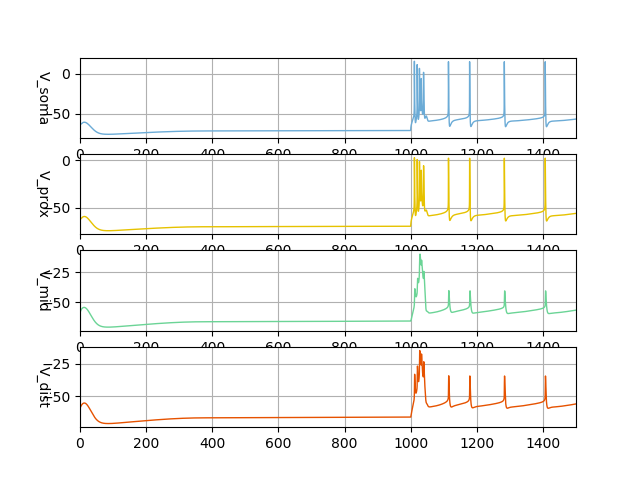

<IPython.core.display.Javascript object>


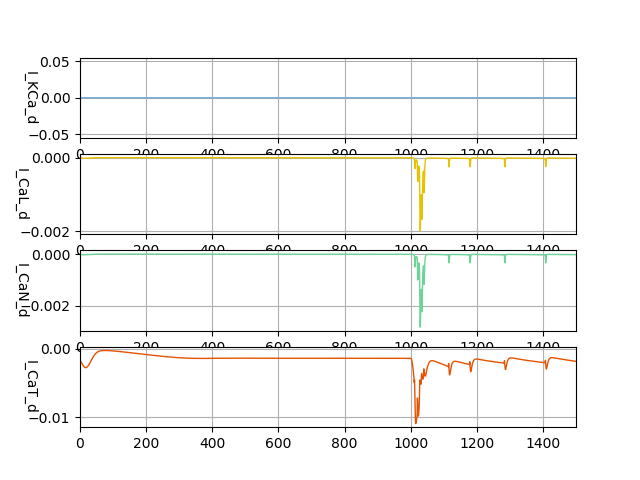

In [11]:
V_traces = [t for t in trace_specs.keys() if t.startswith('V')]
figs_vm = analysis.plotTraces(vec_dict, rec_dt, includeTraces=V_traces, traceSharex=True)

I_dend_traces = [t for t in trace_specs.keys() if t.startswith('I_') and t.endswith('_d')]
figs_vm = analysis.plotTraces(vec_dict, rec_dt, includeTraces=I_dend_traces, oneFigPer='cell')

In [ ]:
# ARTICLE figure
v = vec_dict['V_soma'].as_numpy()
t = vec_dict['t_global'].as_numpy()

# plot signal
fig, ax = plt.subplots(figsize=(0.75*page_width, 0.5*0.75*page_width))
ax.plot(t, v)

# decorate axes
ax.grid(True)
ax.set_xlim((800, 1500))
ax.set_ylim((-90, 25))
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

plotutils.save_figure('stn-reduced_protocol-PLATEAU',
                      fig=fig,
                      dir='/home/luye/cloudstore_m/notes/publications_lkmn/ARTICLE_reduction/figures')


## Protocol ICONST

In [ ]:
# Constant current injected in soma
stim_amp = 0.015
protocol = setup_protocol_ICONST(icell, amp=stim_amp, sim_dur=3000.0)
h.run()

In [ ]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True, includeTraces=['V_soma', 'V_dist'])

In [ ]:
v_soma = vec_dict['V_soma'].as_numpy()
t_global = vec_dict['t_global'].as_numpy()

spike_times = signal.spike_times(v_soma, t_global, v_th=-20.0)
spike_start = 250.0
spike_times = spike_times[spike_times >= spike_start]
spike_rate = len(spike_times) * 1e3 / (h.tstop - spike_start)

print("Spike rate: {:.1f} Hz\n".format(spike_rate))

fI_curve_data = [(0.01, 16.36), (0.015, 20.73), (.02, 25.1), (.03, 33.5), 
                 (0.032, 34.9), (0.035, 37.1), (.05, 47.3), (.1, 76.2)]
fI_curve_data.append((stim_amp, spike_rate))
print('f-I curve data: {}'.format(fI_curve_data))

plt.figure()
I, f = zip(*fI_curve_data)
plt.plot(I, f, 'b*')
plt.grid(True)


## Protocol SYNAPTIC

In [ ]:
# Constant current injected in soma
segments = [icell.dend0[9](.5)] # [icell.soma[0](.5)]

protocol = setup_protocol_SYNAPTIC(
            icell, segments=segments, rate=20, noise=1.0, num_spikes=1e9, 
            tstart=250, gmax=1e-3, ibias=.032)
h.run()

In [ ]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True, includeTraces=['V_soma', 'V_dist'])

# Bevan, Chu (2016)

Can be found on neuromorpho.org using following searches
- [keyword 'subthalamic', sorty by archive](http://neuromorpho.org/KeywordBrowseView.jsp?count=52&keywords=%22subthalamic%22&browseBy=archive)
- [search by brain region 'basal ganglia'](http://neuromorpho.org/byregion.jsp#top)

# Save Notebook

In [ ]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

In [ ]:
from datetime import datetime
nb_filename = 'calibrate_morphologies_STN.ipynb'
report_filename = 'calibrate_morphologies_STN_{}_{}.html'.format(
    template_name, datetime.now().strftime('%Y.%m.%d_%H.%M.%S'))
!jupyter nbconvert $nb_filename --to html --template=toc2 --output $report_filename